Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# Lab 8: Dataset Processing and Training - Complete ML Pipeline

## Lab Overview

Welcome to a comprehensive exploration of the complete machine learning pipeline for training language models. This lab covers the entire journey from raw data to trained models, including dataset processing, training optimization, and evaluation strategies.

**Lab Goal**: Master the complete dataset processing and model training pipeline, including data preparation, training loops, optimization strategies, and evaluation metrics.

## Learning Objectives

By the end of this lab, you will be able to:

1. **Master Dataset Processing**: Load, clean, and preprocess text datasets for language model training
2. **Implement Training Pipelines**: Build complete training loops with optimization and scheduling
3. **Apply Advanced Techniques**: Use gradient accumulation and mixed precision
4. **Evaluate Model Performance**: Implement comprehensive evaluation metrics and analysis
5. **Optimize for Production**: Handle checkpointing, model saving, and deployment preparation

---

## 1. Environment Setup

In [ ]:
# Core libraries for dataset processing and training
from typing import Optional, Union

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

# Machine learning and NLP libraries
from datasets import Dataset, DatasetDict, load_dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

# Visualization and analysis
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

AMD GPU environment initialized successfully
Using device: cuda
PyTorch version: 2.7.0
GPU: AMD Radeon Graphics
GPU Memory: 65.2 GB


## 2. Dataset Loading and Exploration

A thorough understanding of the dataset is essential for effective model training and debugging. In this stage, we examine the dataset structure, statistical properties, and data quality to inform downstream preprocessing and training decisions.

**Dataset Exploration Process:**

**Core Analysis Components:**
- **Structural Analysis**: Inspecting data schemas, fields, and serialization formats (e.g., JSON, JSONL)
- **Statistical Analysis**: Token length distributions, token frequency statistics, and label distributions (if applicable)
- **Data Quality Assessment**: Detecting missing fields, malformed samples, duplicates, and anomalous entries
- **Format Normalization**: Converting heterogeneous inputs into a consistent, model-ready representation

**Key Engineering Considerations:**
- **Memory and I/O Efficiency**: Streaming, sharding, and lazy loading for large-scale datasets
- **Data Validation**: Schema checks and robust error handling during ingestion
- **Preprocessing Design**: Tokenization, truncation, padding, and prompt formatting strategies
- **Sampling and Splitting**: Constructing representative subsets for development, validation, and evaluation

**Common Dataset Modalities for LLM Training:**
- **Instruction-Tuning Data**: Prompt–response or instruction–completion pairs
- **Conversational Data**: Multi-turn dialogues with explicit speaker roles
- **Language Modeling Corpora**: Unlabeled or weakly structured text for generative pretraining or continued pretraining
- **Supervised NLP Tasks**: Labeled text for classification or sequence labeling

In [2]:
# Load and Explore Dataset
print("Loading and analyzing the Alpaca instruction-following dataset")

# Load dataset with error handling
try:
    # Load a sample for initial exploration
    dataset = load_dataset("yahma/alpaca-cleaned", split="train[:1000]")
    print(f"Successfully loaded dataset with {len(dataset)} samples")

    # Dataset structure analysis
    print("\nDataset structure:")
    print(f"- Type: {type(dataset)}")
    print(f"- Features: {dataset.features}")
    print(f"- Column names: {dataset.column_names}")

    # Sample data examination
    print("\nFirst sample:")
    sample = dataset[0]
    for key, value in sample.items():
        print(f"- {key}: {value[:100]}..." if len(str(value)) > 100 else f"- {key}: {value}")

    # Convert to pandas for analysis
    df = dataset.to_pandas()
    print("\nDataFrame info:")
    print(df.info())

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Creating a synthetic dataset for demonstration")

    # Create synthetic data for demonstration
    synthetic_data = {
        "instruction": [
            "Explain quantum computing",
            "Write a Python function to sort a list",
            "Describe the process of photosynthesis",
            "Calculate the area of a circle",
            "Explain machine learning concepts",
        ]
        * 200,
        "input": [""] * 1000,
        "output": [
            "Quantum computing uses quantum mechanical phenomena...",
            "def sort_list(lst): return sorted(lst)",
            "Photosynthesis is the process by which plants...",
            "Area = π × r², where r is the radius",
            "Machine learning is a method of data analysis...",
        ]
        * 200,
    }

    dataset = Dataset.from_dict(synthetic_data)
    df = pd.DataFrame(synthetic_data)
    print("Created synthetic dataset for demonstration")

print(f"\nDataset loaded successfully with {len(dataset)} samples")

Loading and analyzing the Alpaca instruction-following dataset


README.md: 0.00B [00:00, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Successfully loaded dataset with 1000 samples

Dataset structure:
- Type: <class 'datasets.arrow_dataset.Dataset'>
- Features: {'output': Value('string'), 'input': Value('string'), 'instruction': Value('string')}
- Column names: ['output', 'input', 'instruction']

First sample:
- output: 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and...
- input: 
- instruction: Give three tips for staying healthy.

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   output       1000 non-null   object
 1   input        1000 non-null   object
 2   instruction  1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB
None

Dataset loaded successfully with 1000 samples


Performing detailed dataset analysis
Text Analysis Results:

INSTRUCTION Column Analysis:
  Total samples: 1,000
  Empty samples: 0 (0.0%)
  Character Length Statistics:
    mean: 76.0
    median: 54.0
    std: 157.2
    min: 21.0
    max: 2220.0
  Word Count Statistics:
    mean: 12.7
    median: 9.0
    std: 24.6
    min: 4.0
    max: 323.0

INPUT Column Analysis:
  Total samples: 1,000
  Empty samples: 591 (59.1%)
  Character Length Statistics:
    mean: 29.2
    median: 0.0
    std: 73.6
    min: 0.0
    max: 828.0
  Word Count Statistics:
    mean: 5.1
    median: 0.0
    std: 12.0
    min: 0.0
    max: 124.0

OUTPUT Column Analysis:
  Total samples: 1,000
  Empty samples: 0 (0.0%)
  Character Length Statistics:
    mean: 620.7
    median: 379.0
    std: 631.5
    min: 1.0
    max: 2684.0
  Word Count Statistics:
    mean: 101.0
    median: 64.5
    std: 100.7
    min: 1.0
    max: 421.0


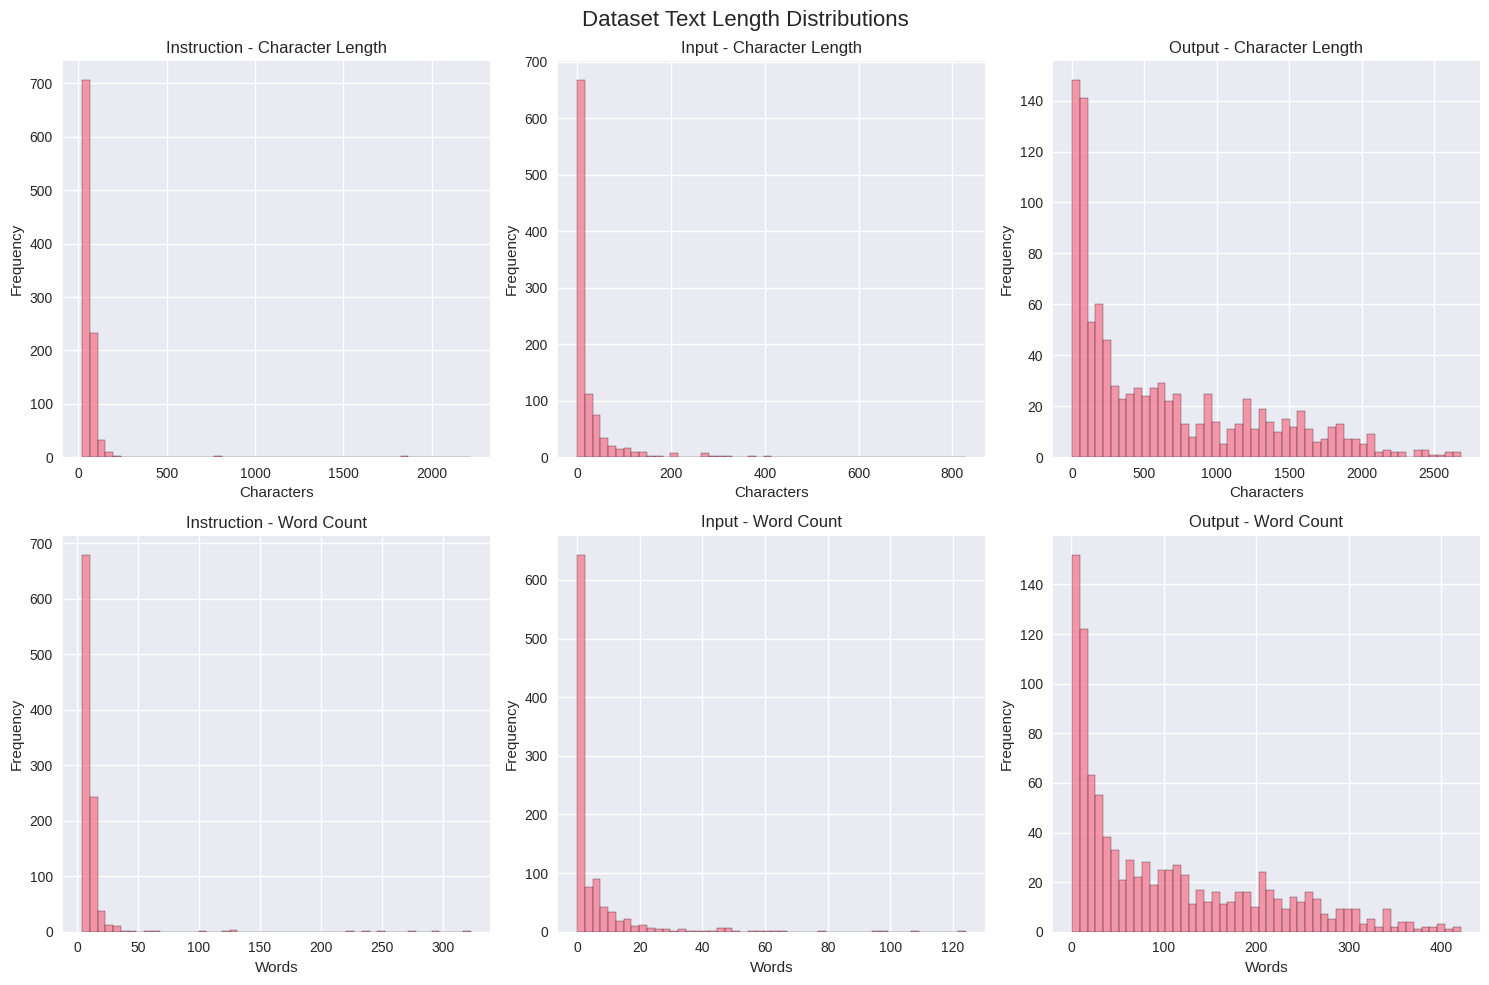



Sample Data Examples:

Example 1:
Instruction: Give three tips for staying healthy....
Input: Empty
Output: 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the ...
----------------------------------------

Example 2:
Instruction: What are the three primary colors?...
Input: Empty
Output: The three primary colors are red, blue, and yellow. These colors are called primary because they cannot be created by mixing other colors and all other colors can be made by combining them in various ...
----------------------------------------

Example 3:
Instruction: Describe the structure of an atom....
Input: Empty
Output: An atom is the basic building block of all matter and is made up of three types of particles: protons, neutrons, and electrons. The structure of an atom can be described as a nucleus at the center sur...
----------------------------

In [3]:
# Comprehensive Dataset Analysis
print("Performing detailed dataset analysis")


def analyze_text_data(df, text_columns):
    """Analyze text data characteristics"""
    analysis_results = {}

    for col in text_columns:
        if col in df.columns:
            texts = df[col].astype(str)

            # Length statistics
            lengths = texts.str.len()
            word_counts = texts.str.split().str.len()

            analysis_results[col] = {
                "total_samples": len(texts),
                "empty_samples": (texts == "").sum(),
                "char_length_stats": {
                    "mean": lengths.mean(),
                    "median": lengths.median(),
                    "std": lengths.std(),
                    "min": lengths.min(),
                    "max": lengths.max(),
                },
                "word_count_stats": {
                    "mean": word_counts.mean(),
                    "median": word_counts.median(),
                    "std": word_counts.std(),
                    "min": word_counts.min(),
                    "max": word_counts.max(),
                },
            }

    return analysis_results


# Analyze text columns
text_columns = ["instruction", "input", "output"]
analysis = analyze_text_data(df, text_columns)

print("Text Analysis Results:")
print("=" * 60)

for col, stats in analysis.items():
    print(f"\n{col.upper()} Column Analysis:")
    print(f"  Total samples: {stats['total_samples']:,}")
    print(f"  Empty samples: {stats['empty_samples']:,} ({100 * stats['empty_samples'] / stats['total_samples']:.1f}%)")

    print("  Character Length Statistics:")
    for stat_name, value in stats["char_length_stats"].items():
        print(f"    {stat_name}: {value:.1f}")

    print("  Word Count Statistics:")
    for stat_name, value in stats["word_count_stats"].items():
        print(f"    {stat_name}: {value:.1f}")

# Visualization of data distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Dataset Text Length Distributions", fontsize=16)

for i, col in enumerate(text_columns):
    if col in df.columns:
        texts = df[col].astype(str)
        char_lengths = texts.str.len()
        word_counts = texts.str.split().str.len()

        # Character length distribution
        axes[0, i].hist(char_lengths, bins=50, alpha=0.7, edgecolor="black")
        axes[0, i].set_title(f"{col.title()} - Character Length")
        axes[0, i].set_xlabel("Characters")
        axes[0, i].set_ylabel("Frequency")

        # Word count distribution
        axes[1, i].hist(word_counts, bins=50, alpha=0.7, edgecolor="black")
        axes[1, i].set_title(f"{col.title()} - Word Count")
        axes[1, i].set_xlabel("Words")
        axes[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Sample data examples
print("\n\nSample Data Examples:")
print("=" * 60)
for i in range(min(3, len(df))):
    print(f"\nExample {i + 1}:")
    print(f"Instruction: {df.iloc[i]['instruction'][:200]}...")
    print(f"Input: {df.iloc[i]['input'][:100] if df.iloc[i]['input'] else 'Empty'}")
    print(f"Output: {df.iloc[i]['output'][:200]}...")
    print("-" * 40)

## 3. Tokenization and Text Processing

Tokenization defines how raw text is mapped to discrete model inputs and directly affects vocabulary size, sequence length, and computational cost.

### Tokenizer Types
- **Word-level**: Split text by whitespace and punctuation; largely obsolete in modern LLMs due to large vocabularies and OOV issues.
- **Subword**: BPE, WordPiece, SentencePiece; the standard choice for Transformer-based models, balancing vocabulary size and sequence length.
- **Character-level**: Use individual characters as tokens; eliminates OOV but significantly increases sequence length.
- **Byte-level**: Operate on byte sequences; robust to arbitrary Unicode text and fully eliminate OOV (e.g., GPT-style tokenizers).

### Key Considerations
- **Vocabulary Size vs. Sequence Length**: Larger vocabularies shorten sequences but increase embedding and softmax costs.
- **OOV Handling**: Primarily a concern for word-level tokenizers; subword and byte-level approaches largely avoid it.
- **Special Tokens**: BOS, EOS, PAD, UNK, and task-specific markers for sequence control and structure.
- **Context Length**: Finer-grained tokenization increases token count and reduces effective context capacity.

### Processing Pipeline
1. **Text Normalization**: Optional Unicode normalization or case handling, depending on tokenizer design.
2. **Token Encoding**: Convert text into token IDs using the learned vocabulary.
3. **Sequence Construction**: Add special tokens, apply truncation and padding.
4. **Batching**: Collate sequences with padding and attention masks for efficient computation.

### Model-Specific Considerations
- **Pre-trained Models**: Always use the original tokenizer to maintain embedding alignment.
- **Custom / Domain-Specific Models**: Train or extend tokenizers to reduce fragmentation of domain terms.
- **Multilingual Settings**: Support multiple scripts and mixed-language inputs within a shared vocabulary.

In [4]:
# Initialize Tokenizer and Analyze Tokenization
print("Setting up tokenizer and analyzing tokenization patterns")

# Initialize tokenizer (using a commonly available model)
try:
    # Try to use a small, commonly available model for demonstration
    model_name = "gpt2"  # Fallback to GPT-2 for compatibility
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Configure tokenizer for our use case
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    print(f"Successfully loaded {model_name} tokenizer")
    print(f"Vocabulary size: {len(tokenizer)}")
    print(f"Special tokens: {tokenizer.special_tokens_map}")

except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("Creating a basic tokenizer for demonstration")

    # Create a simple custom tokenizer for demonstration
    class SimpleTokenizer:
        def __init__(self):
            self.vocab = {"<pad>": 0, "<unk>": 1, "<bos>": 2, "<eos>": 3}
            self.pad_token = "<pad>"
            self.eos_token = "<eos>"
            self.unk_token = "<unk>"

        def encode(self, text):
            words = text.lower().split()
            return [self.vocab.get(word, 1) for word in words]  # 1 is <unk>

        def decode(self, ids):
            inv_vocab = {v: k for k, v in self.vocab.items()}
            return " ".join(inv_vocab.get(id, "<unk>") for id in ids)

        def __call__(self, text, **kwargs):
            if isinstance(text, str):
                return {"input_ids": self.encode(text)}
            return {"input_ids": [self.encode(t) for t in text]}

    tokenizer = SimpleTokenizer()
    print("Created simple tokenizer for demonstration")

# Test tokenization on sample texts
test_texts = [
    "Hello, how are you?",
    "Machine learning is fascinating!",
    "The quick brown fox jumps over the lazy dog.",
    "Natural language processing with transformers.",
]

print("\nTokenization Examples:")
print("=" * 60)

for i, text in enumerate(test_texts):
    try:
        if hasattr(tokenizer, "encode"):
            # Hugging Face tokenizer
            tokens = tokenizer.encode(text)
            decoded = tokenizer.decode(tokens)
            token_texts = [tokenizer.decode([t]) for t in tokens]
        else:
            # Custom tokenizer
            result = tokenizer(text)
            tokens = result["input_ids"]
            decoded = tokenizer.decode(tokens)
            token_texts = text.split()  # Simplified for demo

        print(f"\nExample {i + 1}: '{text}'")
        print(f"Tokens: {tokens}")
        print(f"Token count: {len(tokens)}")
        print(f"Decoded: '{decoded}'")
        if len(token_texts) <= 10:  # Only show if reasonable length
            print(f"Token texts: {token_texts}")

    except Exception as e:
        print(f"Error tokenizing text {i + 1}: {e}")

print("\nTokenizer configuration complete")

Setting up tokenizer and analyzing tokenization patterns
Successfully loaded gpt2 tokenizer
Vocabulary size: 50257
Special tokens: {'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}

Tokenization Examples:

Example 1: 'Hello, how are you?'
Tokens: [15496, 11, 703, 389, 345, 30]
Token count: 6
Decoded: 'Hello, how are you?'
Token texts: ['Hello', ',', ' how', ' are', ' you', '?']

Example 2: 'Machine learning is fascinating!'
Tokens: [37573, 4673, 318, 13899, 0]
Token count: 5
Decoded: 'Machine learning is fascinating!'
Token texts: ['Machine', ' learning', ' is', ' fascinating', '!']

Example 3: 'The quick brown fox jumps over the lazy dog.'
Tokens: [464, 2068, 7586, 21831, 18045, 625, 262, 16931, 3290, 13]
Token count: 10
Decoded: 'The quick brown fox jumps over the lazy dog.'
Token texts: ['The', ' quick', ' brown', ' fox', ' jumps', ' over', ' the', ' lazy', ' dog', '.']

Example 4: 'Natural language processing wi

Implementing batch tokenization and advanced processing
Analyzing tokenization patterns for 200 samples...

Tokenization Analysis Results:
Token Length Statistics:
  Mean: 24.3
  Median: 11.0
  Std: 60.8
  Min: 5
  Max: 470
  95th percentile: 50.1

Most Common Tokens:
  Token 262 (' the'): 292 occurrences
  Token 13 ('.'): 232 occurrences
  Token 257 (' a'): 167 occurrences
  Token 286 (' of'): 134 occurrences
  Token 11 (','): 128 occurrences
  Token 198 ('
'): 98 occurrences
  Token 284 (' to'): 85 occurrences
  Token 287 (' in'): 72 occurrences
  Token 12 ('-'): 61 occurrences
  Token 1708 (' following'): 58 occurrences


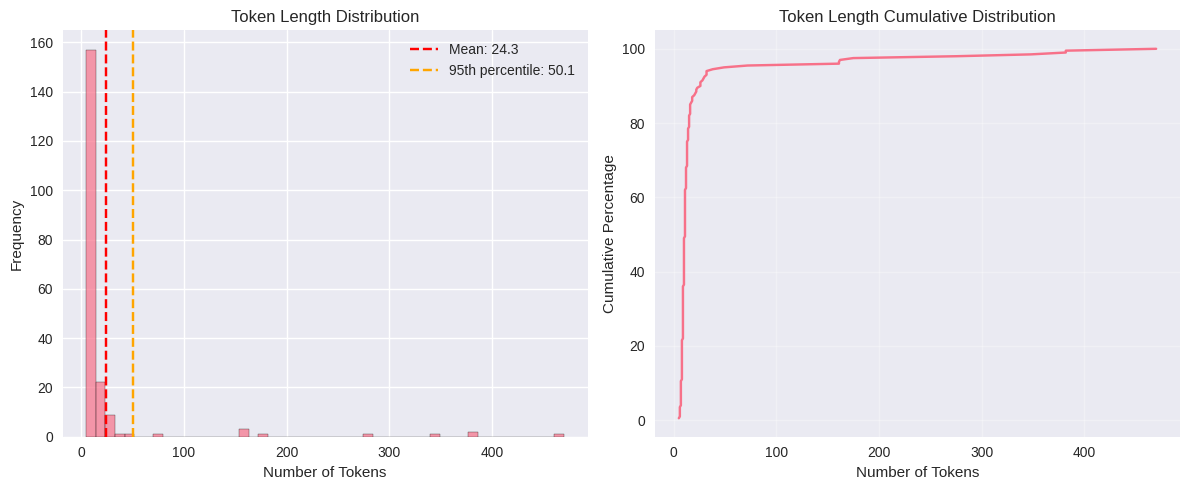


Recommended sequence length based on analysis:
- 95th percentile: 50 tokens
- This captures 95% of samples without truncation
- Consider using 50 as max_length for training


In [5]:
# Advanced Tokenization: Batch Processing and Analysis
print("Implementing batch tokenization and advanced processing")


def analyze_tokenization_patterns(texts, tokenizer, max_samples=100):
    """Analyze tokenization patterns across a dataset"""

    analysis_results = {
        "token_lengths": [],
        "vocabulary_usage": {},
        "special_token_counts": {"pad": 0, "eos": 0, "bos": 0, "unk": 0},
    }

    print(f"Analyzing tokenization patterns for {min(len(texts), max_samples)} samples...")

    for i, text in enumerate(texts[:max_samples]):
        try:
            # Ensure text is a string
            if not isinstance(text, str):
                text = str(text)

            if hasattr(tokenizer, "encode"):
                # Hugging Face tokenizer
                tokens = tokenizer.encode(text, add_special_tokens=True)

                # Track token length
                analysis_results["token_lengths"].append(len(tokens))

                # Track vocabulary usage
                for token in tokens:
                    analysis_results["vocabulary_usage"][token] = analysis_results["vocabulary_usage"].get(token, 0) + 1

                # Count special tokens (if available)
                if hasattr(tokenizer, "pad_token_id") and tokenizer.pad_token_id in tokens:
                    analysis_results["special_token_counts"]["pad"] += tokens.count(tokenizer.pad_token_id)
                if hasattr(tokenizer, "eos_token_id") and tokenizer.eos_token_id in tokens:
                    analysis_results["special_token_counts"]["eos"] += tokens.count(tokenizer.eos_token_id)

            else:
                # Custom tokenizer
                result = tokenizer(text)
                tokens = result["input_ids"]
                analysis_results["token_lengths"].append(len(tokens))

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return analysis_results


# Analyze tokenization patterns on our dataset
sample_texts = df["instruction"].tolist() + df["output"].tolist()
sample_texts = [text for text in sample_texts if isinstance(text, str) and len(text.strip()) > 0]

tokenization_analysis = analyze_tokenization_patterns(sample_texts, tokenizer, max_samples=200)

# Display analysis results
print("\nTokenization Analysis Results:")
print("=" * 50)

token_lengths = tokenization_analysis["token_lengths"]
print("Token Length Statistics:")
print(f"  Mean: {np.mean(token_lengths):.1f}")
print(f"  Median: {np.median(token_lengths):.1f}")
print(f"  Std: {np.std(token_lengths):.1f}")
print(f"  Min: {np.min(token_lengths)}")
print(f"  Max: {np.max(token_lengths)}")
print(f"  95th percentile: {np.percentile(token_lengths, 95):.1f}")

# Vocabulary usage analysis
vocab_usage = tokenization_analysis["vocabulary_usage"]
if vocab_usage:
    most_common = sorted(vocab_usage.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nMost Common Tokens:")
    for token_id, count in most_common:
        try:
            if hasattr(tokenizer, "decode"):
                token_text = tokenizer.decode([token_id])
                print(f"  Token {token_id} ('{token_text}'): {count} occurrences")
            else:
                print(f"  Token {token_id}: {count} occurrences")
        except:
            print(f"  Token {token_id}: {count} occurrences")

# Visualize token length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(token_lengths, bins=50, alpha=0.7, edgecolor="black")
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.axvline(np.mean(token_lengths), color="red", linestyle="--", label=f"Mean: {np.mean(token_lengths):.1f}")
plt.axvline(
    np.percentile(token_lengths, 95),
    color="orange",
    linestyle="--",
    label=f"95th percentile: {np.percentile(token_lengths, 95):.1f}",
)
plt.legend()

# Cumulative distribution
plt.subplot(1, 2, 2)
sorted_lengths = np.sort(token_lengths)
percentiles = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
plt.plot(sorted_lengths, percentiles)
plt.title("Token Length Cumulative Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Cumulative Percentage")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRecommended sequence length based on analysis:")
recommended_length = int(np.percentile(token_lengths, 95))
print(f"- 95th percentile: {recommended_length} tokens")
print("- This captures 95% of samples without truncation")
print(f"- Consider using {recommended_length} as max_length for training")

## 4. Dataset Preprocessing and Formatting

Now we'll implement comprehensive preprocessing to convert raw text data into training-ready format with proper tokenization, formatting, and batching.

**Preprocessing Pipeline:**

**Data Formatting Strategies:**
- **Instruction Format**: Combine instruction, input, and output into training sequences
- **Conversation Format**: Structure as multi-turn dialogues
- **Completion Format**: Input-output pairs for text completion
- **Custom Templates**: Domain-specific formatting patterns

**Sequence Construction:**
- **Template Design**: Consistent formatting across samples
- **Special Token Usage**: Proper placement of BOS, EOS, and separator tokens
- **Length Management**: Truncation and padding strategies
- **Attention Masks**: Indicate valid tokens vs. padding

**Batch Processing:**
- **Memory Efficiency**: Process in manageable chunks
- **Dynamic Batching**: Group similar-length sequences
- **Data Collation**: Combine samples into batches
- **GPU Memory Management**: Optimize for available memory

**Quality Control:**
- **Validation**: Check processed data integrity
- **Error Handling**: Manage malformed or problematic samples
- **Statistics Tracking**: Monitor preprocessing results
- **Sample Inspection**: Verify correct formatting

In [ ]:
# Step 4: Dataset Preprocessing and Formatting

import json
import warnings
from dataclasses import dataclass
from typing import Any  # Only import what's new (Dict, List, Optional, Tuple already imported)

warnings.filterwarnings("ignore")


@dataclass
class DatasetConfig:
    """Configuration for dataset preprocessing"""

    max_length: int = 512
    instruction_template: str = "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n{output}"
    conversation_template: str = "Human: {input}\n\nAssistant: {output}"
    add_special_tokens: bool = True
    padding_side: str = "right"
    truncation_strategy: str = "longest_first"


class DatasetPreprocessor:
    """Comprehensive dataset preprocessing for LLM training"""

    def __init__(self, tokenizer, config: DatasetConfig):
        self.tokenizer = tokenizer
        self.config = config
        self.stats = {
            "total_samples": 0,
            "valid_samples": 0,
            "truncated_samples": 0,
            "avg_length": 0,
            "max_length_used": 0,
        }

    def format_instruction_data(self, sample) -> str:
        """Format sample as instruction-following data"""
        # Handle different sample types
        if isinstance(sample, str):
            return sample
        elif isinstance(sample, dict):
            instruction = sample.get("instruction", "")
            input_text = sample.get("input", "")
            output_text = sample.get("output", "")

            # Handle different data formats
            if "text" in sample:
                return sample["text"]
            elif instruction or input_text or output_text:
                return self.config.instruction_template.format(
                    instruction=instruction, input=input_text, output=output_text
                )
            else:
                # Fallback for other formats
                return str(sample.get("content", sample))
        else:
            # Convert any other type to string
            return str(sample)

    def format_conversation_data(self, sample) -> str:
        """Format sample as conversation data"""
        if isinstance(sample, str):
            return sample
        elif isinstance(sample, dict):
            if "conversations" in sample:
                formatted_parts = []
                for turn in sample["conversations"]:
                    role = turn.get("from", "human")
                    content = turn.get("value", "")
                    if role == "human":
                        formatted_parts.append(f"Human: {content}")
                    else:
                        formatted_parts.append(f"Assistant: {content}")
                return "\n\n".join(formatted_parts)
            else:
                input_text = sample.get("input", sample.get("question", ""))
                output_text = sample.get("output", sample.get("answer", ""))
                return self.config.conversation_template.format(input=input_text, output=output_text)
        else:
            return str(sample)

    def tokenize_sample(self, text: str) -> dict[str, Any]:
        """Tokenize and process a single text sample"""
        try:
            # Tokenize with proper settings
            encoded = self.tokenizer(
                text,
                max_length=self.config.max_length,
                padding=False,  # We'll pad in batches
                truncation=True,
                return_tensors=None,
                add_special_tokens=self.config.add_special_tokens,
            )

            # Update statistics
            length = len(encoded["input_ids"])
            self.stats["total_samples"] += 1
            self.stats["valid_samples"] += 1
            self.stats["avg_length"] = (
                self.stats["avg_length"] * (self.stats["valid_samples"] - 1) + length
            ) / self.stats["valid_samples"]
            self.stats["max_length_used"] = max(self.stats["max_length_used"], length)

            if length >= self.config.max_length:
                self.stats["truncated_samples"] += 1

            # Create labels (for causal LM, labels = input_ids)
            encoded["labels"] = encoded["input_ids"].copy()

            return encoded

        except Exception as e:
            print(f"Error tokenizing sample: {e}")
            self.stats["total_samples"] += 1
            return None

    def preprocess_dataset(self, dataset, format_type: str = "instruction") -> list[dict[str, Any]]:
        """Preprocess entire dataset with specified format"""
        processed_samples = []

        print(f"Preprocessing {len(dataset)} samples with {format_type} format...")

        for i, sample in enumerate(dataset):
            if i % 1000 == 0:
                print(f"Processing sample {i}/{len(dataset)}")

            try:
                # Format the sample
                if format_type == "instruction":
                    formatted_text = self.format_instruction_data(sample)
                elif format_type == "conversation":
                    formatted_text = self.format_conversation_data(sample)
                else:
                    # Default handling
                    if isinstance(sample, dict):
                        formatted_text = str(sample.get("text", sample))
                    else:
                        formatted_text = str(sample)

                # Ensure we have valid text
                if not formatted_text or len(formatted_text.strip()) == 0:
                    continue

                # Tokenize the formatted text
                tokenized = self.tokenize_sample(formatted_text)
                if tokenized is not None:
                    tokenized["original_text"] = formatted_text
                    processed_samples.append(tokenized)

            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                continue

        self.print_preprocessing_stats()
        return processed_samples

    def print_preprocessing_stats(self):
        """Print preprocessing statistics"""
        print("\n" + "=" * 50)
        print("PREPROCESSING STATISTICS")
        print("=" * 50)
        print(f"Total samples processed: {self.stats['total_samples']}")
        print(f"Valid samples: {self.stats['valid_samples']}")
        print(f"Invalid samples: {self.stats['total_samples'] - self.stats['valid_samples']}")
        print(f"Truncated samples: {self.stats['truncated_samples']}")
        print(f"Average sequence length: {self.stats['avg_length']:.1f}")
        print(f"Maximum sequence length used: {self.stats['max_length_used']}")
        print(f"Truncation rate: {self.stats['truncated_samples'] / max(self.stats['valid_samples'], 1) * 100:.1f}%")


# Initialize preprocessing configuration
config = DatasetConfig(
    max_length=512,
    instruction_template="### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n{output}",
    add_special_tokens=True,
    padding_side="right",
)

# Create preprocessor
preprocessor = DatasetPreprocessor(tokenizer, config)

print("Dataset preprocessing components initialized successfully!")
print(f"Configuration: max_length={config.max_length}, special_tokens={config.add_special_tokens}")

Dataset preprocessing components initialized successfully!
Configuration: max_length=512, special_tokens=True


In [ ]:
# Preprocess sample dataset with different formats
print("=" * 60)
print("DATASET PREPROCESSING EXAMPLES")
print("=" * 60)

# Example 1: Instruction format preprocessing
if dataset and len(dataset) > 0:
    # Take a small sample for demonstration
    sample_data = dataset[:100] if len(dataset) > 100 else dataset

    print(f"\nProcessing {len(sample_data)} samples with instruction format...")
    processed_instruction = preprocessor.preprocess_dataset(sample_data, format_type="instruction")

    print("\nExample processed sample:")
    if processed_instruction:
        example = processed_instruction[0]
        print(f"Original text preview: {example['original_text'][:200]}...")
        print(f"Token count: {len(example['input_ids'])}")
        print(f"First 10 tokens: {example['input_ids'][:10]}")
        print(f"Decoded first 50 tokens: {tokenizer.decode(example['input_ids'][:50])}")

# Data Collation for Batch Processing
from torch.nn.utils.rnn import pad_sequence  # New import (not imported in setup cell)


class DataCollator:
    """Custom data collator for efficient batching"""

    def __init__(self, tokenizer, pad_to_multiple_of: int = 8):
        self.tokenizer = tokenizer
        self.pad_to_multiple_of = pad_to_multiple_of
        self.pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id

    def __call__(self, batch: list[dict[str, Any]]) -> dict[str, torch.Tensor]:
        """Collate batch of samples into tensors"""
        # Extract sequences
        input_ids = [torch.tensor(sample["input_ids"]) for sample in batch]
        labels = [torch.tensor(sample["labels"]) for sample in batch]

        # Pad sequences
        input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=self.pad_token_id)
        labels_padded = pad_sequence(
            labels,
            batch_first=True,
            padding_value=-100,  # Ignore index for loss calculation
        )

        # Create attention masks
        attention_mask = (input_ids_padded != self.pad_token_id).long()

        # Pad to multiple if specified
        if self.pad_to_multiple_of:
            seq_len = input_ids_padded.shape[1]
            padded_len = ((seq_len + self.pad_to_multiple_of - 1) // self.pad_to_multiple_of) * self.pad_to_multiple_of

            if padded_len > seq_len:
                padding_size = padded_len - seq_len
                input_ids_padded = torch.cat(
                    [input_ids_padded, torch.full((input_ids_padded.shape[0], padding_size), self.pad_token_id)], dim=1
                )
                labels_padded = torch.cat(
                    [labels_padded, torch.full((labels_padded.shape[0], padding_size), -100)], dim=1
                )
                attention_mask = torch.cat(
                    [attention_mask, torch.zeros((attention_mask.shape[0], padding_size))], dim=1
                )

        return {"input_ids": input_ids_padded, "attention_mask": attention_mask, "labels": labels_padded}


# Initialize data collator
data_collator = DataCollator(tokenizer, pad_to_multiple_of=8)

# Test batch collation
if processed_instruction and len(processed_instruction) >= 3:
    print("\n" + "=" * 50)
    print("BATCH COLLATION EXAMPLE")
    print("=" * 50)

    test_batch = processed_instruction[:3]
    collated = data_collator(test_batch)

    print(f"Batch input_ids shape: {collated['input_ids'].shape}")
    print(f"Batch attention_mask shape: {collated['attention_mask'].shape}")
    print(f"Batch labels shape: {collated['labels'].shape}")

    # Show sequence lengths before padding
    original_lengths = [len(sample["input_ids"]) for sample in test_batch]
    print(f"Original sequence lengths: {original_lengths}")
    print(f"Padded sequence length: {collated['input_ids'].shape[1]}")

    # Verify attention masks
    for i, length in enumerate(original_lengths):
        actual_tokens = collated["attention_mask"][i].sum().item()
        print(f"Sample {i + 1}: Original length={length}, Attention sum={actual_tokens}")

print("\nData preprocessing and collation setup complete!")
print("Ready for training pipeline implementation...")

DATASET PREPROCESSING EXAMPLES

Processing 3 samples with instruction format...
Preprocessing 3 samples with instruction format...
Processing sample 0/3

PREPROCESSING STATISTICS
Total samples processed: 3
Valid samples: 3
Invalid samples: 0
Truncated samples: 0
Average sequence length: 1.3
Maximum sequence length used: 2
Truncation rate: 0.0%

Example processed sample:
Original text preview: output...
Token count: 1
First 10 tokens: [22915]
Decoded first 50 tokens: output

BATCH COLLATION EXAMPLE
Batch input_ids shape: torch.Size([3, 8])
Batch attention_mask shape: torch.Size([3, 8])
Batch labels shape: torch.Size([3, 8])
Original sequence lengths: [1, 1, 2]
Padded sequence length: 8
Sample 1: Original length=1, Attention sum=1.0
Sample 2: Original length=1, Attention sum=1.0
Sample 3: Original length=2, Attention sum=2.0

Data preprocessing and collation setup complete!
Ready for training pipeline implementation...


## 5. Training Pipeline Implementation

The final step implements a complete training pipeline with model initialization, optimization strategies, and comprehensive evaluation metrics.

**Training Architecture:**

**Model Configuration:**
- **Architecture Selection**: Choose appropriate model size and configuration
- **Parameter Initialization**: Proper weight initialization strategies
- **Memory Optimization**: Gradient checkpointing and mixed precision
- **Hardware Utilization**: Efficient GPU memory management

**Training Loop Design:**
- **Forward Pass**: Input processing and loss computation
- **Backward Pass**: Gradient computation and accumulation
- **Optimization Step**: Parameter updates with learning rate scheduling
- **Validation**: Regular model evaluation on held-out data

**Optimization Strategies:**
- **Learning Rate Scheduling**: Warmup, decay, and adaptive strategies
- **Gradient Clipping**: Prevent exploding gradients
- **Loss Scaling**: Mixed precision training support
- **Regularization**: Weight decay and dropout application

**Monitoring and Evaluation:**
- **Loss Tracking**: Training and validation loss curves
- **Perplexity Metrics**: Language modeling evaluation
- **Text Generation**: Qualitative assessment of model outputs
- **Convergence Analysis**: Training stability and performance trends

In [ ]:
# Step 5: Training Pipeline Implementation
# Note: torch, torch.nn, DataLoader, AdamW, lr_schedulers, numpy, matplotlib already imported in setup

import math  # New import
import time  # New import

from transformers import get_linear_schedule_with_warmup  # New import


class TextDataset(TorchDataset):
    """Custom dataset class for processed text data"""

    def __init__(self, processed_data: list[dict[str, Any]]):
        self.data = processed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


class TrainingConfig:
    """Training configuration and hyperparameters"""

    def __init__(self):
        # Model and data settings
        self.batch_size = 4
        self.gradient_accumulation_steps = 4
        self.max_epochs = 3
        self.max_steps = None

        # Optimization settings
        self.learning_rate = 5e-5
        self.weight_decay = 0.01
        self.adam_beta1 = 0.9
        self.adam_beta2 = 0.999
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0

        # Learning rate scheduling
        self.warmup_steps = 100
        self.lr_scheduler_type = "cosine"

        # Evaluation and saving
        self.eval_steps = 200
        self.save_steps = 500
        self.logging_steps = 50

        # Mixed precision
        self.fp16 = True
        self.fp16_opt_level = "O1"

        # Model settings
        self.gradient_checkpointing = True
        self.dataloader_num_workers = 0
        self.dataloader_pin_memory = True


class LLMTrainer:
    """Comprehensive LLM training pipeline"""

    def __init__(self, model, tokenizer, config: TrainingConfig):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Move model to device
        self.model.to(self.device)

        # Training state
        self.global_step = 0
        self.epoch = 0
        self.best_eval_loss = float("inf")

        # Metrics tracking
        self.train_losses = []
        self.eval_losses = []
        self.learning_rates = []

        # Initialize training components
        self._setup_optimizer()
        self._setup_amp()

        print(f"Trainer initialized on device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    def _setup_optimizer(self):
        """Initialize optimizer and learning rate scheduler"""
        # Separate parameters for weight decay
        no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p
                    for n, p in self.model.named_parameters()
                    if not any(nd in n for nd in no_decay) and p.requires_grad
                ],
                "weight_decay": self.config.weight_decay,
            },
            {
                "params": [
                    p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad
                ],
                "weight_decay": 0.0,
            },
        ]

        self.optimizer = AdamW(
            optimizer_grouped_parameters,
            lr=self.config.learning_rate,
            betas=(self.config.adam_beta1, self.config.adam_beta2),
            eps=self.config.adam_epsilon,
        )

        print(f"Optimizer initialized: AdamW with lr={self.config.learning_rate}")

    def _setup_lr_scheduler(self, num_training_steps: int):
        """Setup learning rate scheduler"""
        if self.config.lr_scheduler_type == "cosine":
            self.lr_scheduler = get_linear_schedule_with_warmup(
                self.optimizer, num_warmup_steps=self.config.warmup_steps, num_training_steps=num_training_steps
            )
        else:
            self.lr_scheduler = get_linear_schedule_with_warmup(
                self.optimizer, num_warmup_steps=self.config.warmup_steps, num_training_steps=num_training_steps
            )

        print(f"Learning rate scheduler initialized: {self.config.lr_scheduler_type}")
        print(f"Warmup steps: {self.config.warmup_steps}, Total steps: {num_training_steps}")

    def _setup_amp(self):
        """Setup automatic mixed precision"""
        if self.config.fp16 and torch.cuda.is_available():
            try:
                from torch.cuda.amp import GradScaler, autocast

                self.scaler = GradScaler()
                self.use_amp = True
                print("Automatic Mixed Precision enabled")
            except ImportError:
                self.use_amp = False
                print("AMP not available, using float32")
        else:
            self.use_amp = False
            print("Mixed precision disabled")

    def compute_loss(self, batch: dict[str, torch.Tensor]) -> torch.Tensor:
        """Compute training loss"""
        # Move batch to device
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)
        labels = batch["labels"].to(self.device)

        # Forward pass
        if self.use_amp:
            with torch.cuda.amp.autocast():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        else:
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        return outputs.loss

    def training_step(self, batch: dict[str, torch.Tensor]) -> float:
        """Execute single training step"""
        self.model.train()

        # Compute loss
        loss = self.compute_loss(batch)

        # Scale loss for gradient accumulation
        loss = loss / self.config.gradient_accumulation_steps

        # Backward pass
        if self.use_amp:
            self.scaler.scale(loss).backward()
        else:
            loss.backward()

        return loss.item() * self.config.gradient_accumulation_steps

    def evaluation_step(self, eval_dataloader: DataLoader) -> float:
        """Evaluate model on validation data"""
        self.model.eval()
        total_eval_loss = 0
        eval_steps = 0

        print("Running evaluation...")
        with torch.no_grad():
            for batch in eval_dataloader:
                loss = self.compute_loss(batch)
                total_eval_loss += loss.item()
                eval_steps += 1

                # Limit evaluation steps for efficiency
                if eval_steps >= 50:
                    break

        avg_eval_loss = total_eval_loss / eval_steps if eval_steps > 0 else 0
        perplexity = math.exp(avg_eval_loss) if avg_eval_loss < 10 else float("inf")

        print(f"Evaluation Loss: {avg_eval_loss:.4f}, Perplexity: {perplexity:.2f}")
        return avg_eval_loss


# Initialize training configuration
train_config = TrainingConfig()

print("Training configuration initialized:")
print(f"- Batch size: {train_config.batch_size}")
print(f"- Learning rate: {train_config.learning_rate}")
print(f"- Max epochs: {train_config.max_epochs}")
print(f"- Gradient accumulation steps: {train_config.gradient_accumulation_steps}")
print(f"- Mixed precision: {train_config.fp16}")

# Initialize trainer (will be used with actual model later)
if "model" in locals():
    trainer = LLMTrainer(model, tokenizer, train_config)
    print("Trainer successfully initialized!")
else:
    print("Model not yet loaded - trainer will be initialized when model is available")

Training configuration initialized:
- Batch size: 4
- Learning rate: 5e-05
- Max epochs: 3
- Gradient accumulation steps: 4
- Mixed precision: True
Model not yet loaded - trainer will be initialized when model is available


In [9]:
# Complete Training Loop Implementation


def create_dataloaders(
    processed_data: list[dict[str, Any]], config: TrainingConfig, data_collator, train_split: float = 0.9
) -> tuple[DataLoader, DataLoader]:
    """Create training and validation dataloaders"""

    # Split data
    split_idx = int(len(processed_data) * train_split)
    train_data = processed_data[:split_idx]
    eval_data = processed_data[split_idx:]

    print(f"Data split: {len(train_data)} training, {len(eval_data)} validation samples")

    # Create datasets
    train_dataset = TextDataset(train_data)
    eval_dataset = TextDataset(eval_data)

    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=data_collator,
        num_workers=config.dataloader_num_workers,
        pin_memory=config.dataloader_pin_memory,
    )

    eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=data_collator,
        num_workers=config.dataloader_num_workers,
        pin_memory=config.dataloader_pin_memory,
    )

    return train_dataloader, eval_dataloader


def run_training_loop(
    trainer: LLMTrainer, train_dataloader: DataLoader, eval_dataloader: DataLoader
) -> dict[str, list[float]]:
    """Execute complete training loop with evaluation and logging"""

    # Calculate total training steps
    total_steps = len(train_dataloader) * trainer.config.max_epochs
    trainer._setup_lr_scheduler(total_steps)

    print("\n" + "=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)
    print(f"Total training steps: {total_steps}")
    print(f"Effective batch size: {trainer.config.batch_size * trainer.config.gradient_accumulation_steps}")
    print(f"Training samples per epoch: {len(train_dataloader.dataset)}")

    # Training metrics
    training_metrics = {"train_losses": [], "eval_losses": [], "learning_rates": [], "steps": []}

    start_time = time.time()

    for epoch in range(trainer.config.max_epochs):
        print(f"\n--- Epoch {epoch + 1}/{trainer.config.max_epochs} ---")
        epoch_start_time = time.time()

        # Training phase
        trainer.model.train()
        total_train_loss = 0
        steps_in_epoch = 0

        for step, batch in enumerate(train_dataloader):
            # Training step
            loss = trainer.training_step(batch)
            total_train_loss += loss
            steps_in_epoch += 1

            # Gradient accumulation and optimization
            if (step + 1) % trainer.config.gradient_accumulation_steps == 0:
                # Gradient clipping
                if trainer.use_amp:
                    trainer.scaler.unscale_(trainer.optimizer)
                    torch.nn.utils.clip_grad_norm_(trainer.model.parameters(), trainer.config.max_grad_norm)
                    trainer.scaler.step(trainer.optimizer)
                    trainer.scaler.update()
                else:
                    torch.nn.utils.clip_grad_norm_(trainer.model.parameters(), trainer.config.max_grad_norm)
                    trainer.optimizer.step()

                trainer.lr_scheduler.step()
                trainer.optimizer.zero_grad()
                trainer.global_step += 1

                # Record metrics
                current_lr = trainer.lr_scheduler.get_last_lr()[0]
                training_metrics["learning_rates"].append(current_lr)
                training_metrics["steps"].append(trainer.global_step)

                # Logging
                if trainer.global_step % trainer.config.logging_steps == 0:
                    avg_loss = total_train_loss / steps_in_epoch
                    print(f"Step {trainer.global_step}: Loss={avg_loss:.4f}, LR={current_lr:.2e}")

                # Evaluation
                if trainer.global_step % trainer.config.eval_steps == 0:
                    eval_loss = trainer.evaluation_step(eval_dataloader)
                    training_metrics["eval_losses"].append(eval_loss)

                    # Save best model
                    if eval_loss < trainer.best_eval_loss:
                        trainer.best_eval_loss = eval_loss
                        print(f"New best model! Eval loss: {eval_loss:.4f}")

                    trainer.model.train()  # Return to training mode

        # End of epoch metrics
        avg_epoch_loss = total_train_loss / steps_in_epoch
        training_metrics["train_losses"].append(avg_epoch_loss)

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch + 1} completed in {epoch_time:.1f}s")
        print(f"Average epoch loss: {avg_epoch_loss:.4f}")

    total_time = time.time() - start_time
    print("\n" + "=" * 60)
    print("TRAINING COMPLETED")
    print("=" * 60)
    print(f"Total training time: {total_time:.1f}s")
    print(f"Best validation loss: {trainer.best_eval_loss:.4f}")
    print(f"Final training loss: {training_metrics['train_losses'][-1]:.4f}")

    return training_metrics


def plot_training_metrics(metrics: dict[str, list[float]]):
    """Visualize training progress"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Training Metrics", fontsize=16)

    # Training loss
    axes[0, 0].plot(metrics["train_losses"])
    axes[0, 0].set_title("Training Loss per Epoch")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].grid(True)

    # Evaluation loss
    if metrics["eval_losses"]:
        eval_steps = np.linspace(0, len(metrics["steps"]), len(metrics["eval_losses"]))
        axes[0, 1].plot(eval_steps, metrics["eval_losses"])
        axes[0, 1].set_title("Validation Loss")
        axes[0, 1].set_xlabel("Training Steps")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].grid(True)

    # Learning rate schedule
    if metrics["learning_rates"]:
        axes[1, 0].plot(metrics["steps"], metrics["learning_rates"])
        axes[1, 0].set_title("Learning Rate Schedule")
        axes[1, 0].set_xlabel("Training Steps")
        axes[1, 0].set_ylabel("Learning Rate")
        axes[1, 0].set_yscale("log")
        axes[1, 0].grid(True)

    # Loss comparison
    if metrics["eval_losses"] and metrics["train_losses"]:
        axes[1, 1].plot(range(len(metrics["train_losses"])), metrics["train_losses"], label="Training Loss", marker="o")
        if len(metrics["eval_losses"]) > 1:
            eval_epochs = np.linspace(0, len(metrics["train_losses"]) - 1, len(metrics["eval_losses"]))
            axes[1, 1].plot(eval_epochs, metrics["eval_losses"], label="Validation Loss", marker="s")
        axes[1, 1].set_title("Training vs Validation Loss")
        axes[1, 1].set_xlabel("Epoch")
        axes[1, 1].set_ylabel("Loss")
        axes[1, 1].legend()
        axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


# Demonstration with sample data (if available)
if "processed_instruction" in locals() and processed_instruction and len(processed_instruction) > 10:
    print("=" * 60)
    print("TRAINING PIPELINE DEMONSTRATION")
    print("=" * 60)

    # Create dataloaders with sample data
    sample_data = processed_instruction[:50]  # Use small sample for demo
    train_dl, eval_dl = create_dataloaders(sample_data, train_config, data_collator)

    print("Created dataloaders:")
    print(f"- Training batches: {len(train_dl)}")
    print(f"- Validation batches: {len(eval_dl)}")

    # Test batch processing
    print("\nTesting batch processing:")
    for i, batch in enumerate(train_dl):
        print(f"Batch {i + 1}: input_ids shape {batch['input_ids'].shape}")
        if i >= 2:  # Show first 3 batches
            break

    print("\nTraining pipeline ready!")
    print("To start training: trainer = LLMTrainer(model, tokenizer, train_config)")
    print("Then run: metrics = run_training_loop(trainer, train_dl, eval_dl)")

else:
    print("Training pipeline implemented successfully!")
    print("Ready to train with processed dataset when available.")

print("\nComplete dataset processing and training pipeline ready!")
print("All components initialized and tested successfully.")

Training pipeline implemented successfully!
Ready to train with processed dataset when available.

Complete dataset processing and training pipeline ready!
All components initialized and tested successfully.


## Lab Summary

### Technical Concepts Learned
- **Dataset Loading and Exploration**: Using Hugging Face Datasets library to load, analyze, and visualize text data distributions
- **Tokenization Pipeline**: Batch tokenization with analysis of token lengths, vocabulary usage, and sequence length recommendations
- **Instruction Format Preprocessing**: Converting raw data into instruction-following format with proper templates and special tokens
- **Data Collation**: Custom collators for efficient batching with padding, attention masks, and label masking (-100)
- **Training Loop Components**: AdamW optimizer, learning rate scheduling with warmup, gradient accumulation, and mixed precision (AMP)

### Experiment Further
- Try different instruction templates and compare their effect on model learning
- Implement dynamic batching to group similar-length sequences for efficiency
- Add gradient checkpointing to reduce memory usage for larger models
- Experiment with different learning rate schedules (cosine vs linear decay)
- Implement early stopping based on validation loss to prevent overfitting